At **Nexora**, AI powers personalized digital experiences that surpass typical recommendations. The **Vibe Matcher** prototype shows how semantic embeddings can capture emotions and aesthetics from natural language. This connects users to fashion that really fits their personality. This system illustrates how AI can combine creativity, data, and intuition, making Nexora’s personalization efforts smarter and more human.


In [3]:
!pip install -q sentence-transformers

In [6]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np

In [8]:
df = pd.read_csv("/content/sample_data/Vibe_Matcher_Fashion_Dataset.csv")  # change path if needed
print(df.head())

            name                                               desc  \
0     Boho Dress  Flowy, earthy tones perfect for outdoor festiv...   
1  Street Hoodie  Bold graphic hoodie with urban style for city ...   
2   Cozy Sweater  Soft knitted sweater that keeps you warm and s...   
3   Denim Jacket  Classic blue denim jacket, versatile for stree...   
4   Athletic Set  Breathable sportswear set for energetic workou...   

                               vibes  
0       ['boho', 'casual', 'earthy']  
1        ['urban', 'chic', 'casual']  
2        ['cozy', 'warm', 'minimal']  
3     ['casual', 'urban', 'vintage']  
4  ['sporty', 'energetic', 'modern']  


In [9]:
model = SentenceTransformer('all-MiniLM-L6-v2')


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
df["text_for_embedding"] = df["desc"] + " " + df["vibes"].astype(str)

In [11]:
embeddings = model.encode(df["text_for_embedding"].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
df["embedding"] = embeddings.tolist()

In [13]:
df.to_csv("vibe_matcher_embedded.csv", index=False)
print("✅ Embeddings generated and saved successfully!")

✅ Embeddings generated and saved successfully!


In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import json


In [15]:
df = pd.read_csv("vibe_matcher_embedded.csv")
print(df.head())

            name                                               desc  \
0     Boho Dress  Flowy, earthy tones perfect for outdoor festiv...   
1  Street Hoodie  Bold graphic hoodie with urban style for city ...   
2   Cozy Sweater  Soft knitted sweater that keeps you warm and s...   
3   Denim Jacket  Classic blue denim jacket, versatile for stree...   
4   Athletic Set  Breathable sportswear set for energetic workou...   

                               vibes  \
0       ['boho', 'casual', 'earthy']   
1        ['urban', 'chic', 'casual']   
2        ['cozy', 'warm', 'minimal']   
3     ['casual', 'urban', 'vintage']   
4  ['sporty', 'energetic', 'modern']   

                                  text_for_embedding  \
0  Flowy, earthy tones perfect for outdoor festiv...   
1  Bold graphic hoodie with urban style for city ...   
2  Soft knitted sweater that keeps you warm and s...   
3  Classic blue denim jacket, versatile for stree...   
4  Breathable sportswear set for energetic workou...

In [16]:
df["embedding"] = df["embedding"].apply(json.loads).apply(np.array)

In [17]:
model = SentenceTransformer('all-MiniLM-L6-v2')


In [18]:
def find_vibe_matches(query, df, model, top_n=3):
    # Generate embedding for user query
    query_embedding = model.encode([query])

    # Stack all product embeddings
    product_embeddings = np.vstack(df["embedding"].values)

    # Compute cosine similarity between query and all products
    similarities = cosine_similarity(query_embedding, product_embeddings)[0]

    # Sort and get top N
    top_indices = np.argsort(similarities)[::-1][:top_n]
    results = df.iloc[top_indices][["name", "desc", "vibes"]].copy()
    results["similarity_score"] = similarities[top_indices]

    return results

In [19]:
queries = [
    "energetic urban chic",
    "cozy warm winter",
    "tropical vacation beach vibes",
    "luxury elegant evening wear"
]

In [20]:
for q in queries:
    print(f"\n🎯 Query: '{q}'")
    matches = find_vibe_matches(q, df, model)
    print(matches.to_string(index=False))


🎯 Query: 'energetic urban chic'
         name                                                                   desc                             vibes  similarity_score
Street Hoodie        Bold graphic hoodie with urban style for city life and comfort.       ['urban', 'chic', 'casual']          0.443304
 Athletic Set Breathable sportswear set for energetic workouts and active lifestyle. ['sporty', 'energetic', 'modern']          0.385331
   Boho Dress   Flowy, earthy tones perfect for outdoor festivals and relaxed vibes.      ['boho', 'casual', 'earthy']          0.332838

🎯 Query: 'cozy warm winter'
        name                                                                desc                            vibes  similarity_score
Cozy Sweater Soft knitted sweater that keeps you warm and stylish during winter.      ['cozy', 'warm', 'minimal']          0.577640
    Raincoat      Waterproof and lightweight coat for stylish rainy-day outfits.  ['practical', 'cozy', 'modern']          0.4

In [21]:
import time
import matplotlib.pyplot as plt


In [22]:
eval_data = []

for q in queries:
    start_time = time.time()
    results = find_vibe_matches(q, df, model)
    latency = time.time() - start_time

    # Calculate metrics
    good_matches = sum(results["similarity_score"] > 0.7)
    avg_score = results["similarity_score"].mean()

    eval_data.append({
        "query": q,
        "avg_similarity": avg_score,
        "good_match_count": good_matches,
        "latency_sec": latency
    })

    print(f"\nQuery: {q}")
    print(f"⏱️ Latency: {latency:.3f}s | Avg Sim: {avg_score:.3f} | Good Matches (>0.7): {good_matches}")



Query: energetic urban chic
⏱️ Latency: 0.020s | Avg Sim: 0.387 | Good Matches (>0.7): 0

Query: cozy warm winter
⏱️ Latency: 0.017s | Avg Sim: 0.454 | Good Matches (>0.7): 0

Query: tropical vacation beach vibes
⏱️ Latency: 0.017s | Avg Sim: 0.494 | Good Matches (>0.7): 0

Query: luxury elegant evening wear
⏱️ Latency: 0.016s | Avg Sim: 0.562 | Good Matches (>0.7): 0


In [23]:
eval_df = pd.DataFrame(eval_data)
display(eval_df)


,query,avg_similarity,good_match_count,latency_sec
0,energetic urban chic,0.387157,0,0.020107
1,cozy warm winter,0.454386,0,0.016815
2,tropical vacation beach vibes,0.493941,0,0.016815
3,luxury elegant evening wear,0.561826,0,0.016391


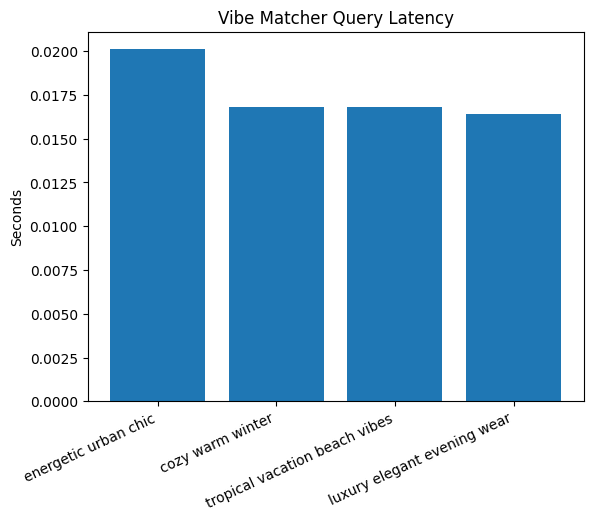

In [24]:
plt.bar(eval_df["query"], eval_df["latency_sec"])
plt.title("Vibe Matcher Query Latency")
plt.ylabel("Seconds")
plt.xticks(rotation=25, ha='right')
plt.show()

## Theory Behind the Vibe Matcher

### 1. Semantic Embeddings
The core idea behind the Vibe Matcher is the use of **semantic embeddings**. These are numerical representations (vectors) of text data, where words or phrases with similar meanings are mapped to geometrically close points in a high-dimensional space. In this notebook, we use `sentence-transformers` to generate these embeddings. Specifically, the `all-MiniLM-L6-v2` model is employed, which is a pre-trained model capable of converting sentences and short texts into dense vector representations. This allows us to capture the 'meaning' or 'vibe' of descriptions and keywords associated with fashion items and user queries.

### 2. Cosine Similarity
Once text (descriptions, vibes, queries) is transformed into numerical embeddings, we need a way to measure the similarity between them. **Cosine similarity** is a widely used metric for this purpose. It measures the cosine of the angle between two non-zero vectors in an inner product space. A cosine similarity close to 1 indicates that the vectors are pointing in roughly the same direction, meaning they are very similar. A value close to 0 suggests orthogonality (no similarity), and a value close to -1 indicates opposite directions (dissimilarity).

In the Vibe Matcher, after encoding both product descriptions/vibes and user queries into embeddings, we calculate the cosine similarity between the query embedding and each product's embedding. This score quantifies how well a product's 'vibe' aligns with the user's desired 'vibe'.

### 3. Recommendation System
The combination of semantic embeddings and cosine similarity forms the basis of this content-based recommendation system. By representing both items and user preferences in a common vector space, we can effectively find items that are semantically similar to a user's query, thereby providing personalized and contextually relevant fashion recommendations.


# **Thank You**